In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(color_codes=True) #导入seaborn包设定颜色

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn import metrics

In [2]:
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

In [3]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
 
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
 
    plt.legend(loc="best")
    return plt

In [4]:
# create raw dataframe
df_raw = pd.read_excel("MedicalCentre.xlsx")
df = df_raw.copy()

In [5]:
# rename wrong columns

# drop definitely useless columns
df.drop('PatientId', axis=1, inplace=True)
df.drop('AppointmentID', axis=1, inplace=True)

In [6]:
# dealing with missing data
df.isnull().sum()

Gender            0
ScheduledDay      0
AppointmentDay    0
Age               0
Neighbourhood     0
Scholarship       0
Hipertension      0
Diabetes          0
Alcoholism        0
Handcap           0
SMS_received      0
No-show           0
dtype: int64

In [7]:
# determine the frequency of each value in features
columns = df.columns
for i in columns:
    print(df[i].value_counts(normalize = True))
    print("\n")

F    0.649977
M    0.350023
Name: Gender, dtype: float64


2016-05-06T07:09:54Z    0.000217
2016-05-06T07:09:53Z    0.000208
2016-04-25T17:18:27Z    0.000199
2016-04-25T17:17:46Z    0.000199
2016-04-25T17:17:23Z    0.000172
                          ...   
2016-05-02T09:53:25Z    0.000009
2016-05-30T09:12:28Z    0.000009
2016-05-16T09:10:04Z    0.000009
2016-05-09T10:17:48Z    0.000009
2016-04-27T13:30:56Z    0.000009
Name: ScheduledDay, Length: 103549, dtype: float64


2016-06-06T00:00:00Z    0.042451
2016-05-16T00:00:00Z    0.041736
2016-05-09T00:00:00Z    0.040895
2016-05-30T00:00:00Z    0.040841
2016-06-08T00:00:00Z    0.040524
2016-05-11T00:00:00Z    0.040479
2016-06-01T00:00:00Z    0.040388
2016-06-07T00:00:00Z    0.039954
2016-05-12T00:00:00Z    0.039755
2016-05-02T00:00:00Z    0.039592
2016-05-18T00:00:00Z    0.039565
2016-05-17T00:00:00Z    0.039556
2016-06-02T00:00:00Z    0.038995
2016-05-10T00:00:00Z    0.038977
2016-05-31T00:00:00Z    0.038715
2016-05-05T00:00:00Z    0.0386

In [8]:
# plot all features within the dataset to visualize for outliers
# sns.histplot(df['Age'])
# plt.subplot(2, 2, 1)
# sns.boxplot(x = df['Age'])
# plt.subplot(2, 2, 2)
# sns.countplot(x = df['Gender'])
# plt.subplot(2, 2, 3)
# sns.countplot(x = df['WaitingTime'])
# plt.subplot(2, 2, 4)
# sns.countplot(x = df['No-show'])
# plt.show()

In [9]:
# "Time" processing
# timlize the data from these two columns
df['ScheduledDay'] = pd.to_datetime(df_raw['ScheduledDay'], errors='ignore')
df['AppointmentDay'] = pd.to_datetime(df_raw['AppointmentDay'], errors='ignore')

# create the column of waiting time
df['WaitingTime'] = df['AppointmentDay'] - df['ScheduledDay']
# convert it into day format and eliminate the negative ones
df['WaitingTime']= df['WaitingTime'].apply(lambda x: x.days) + 1

# normalize waiting time
df['WaitingTime'] = (df['WaitingTime'] - df['WaitingTime'].min()) / \
(df['WaitingTime'].max() - df['WaitingTime'].min())



In [10]:
# "Age" processing
# eliminate the outliers of ages which are < 0, or > 100
# df = df[df['Age']>=0]
# df = df[df['Age']<=100]
df = df[(df['Age']>=0) & (df['Age']<=100)]

# normalize the age column
df['Age'] = (df['Age'] - df['Age'].min()) / (df['Age'].max() - df['Age'].min())

In [11]:
# "Neighbourhood" processing
# df.drop('Neighbourhood', axis=1, inplace=True)
neighbourmap = {elem:index+1 for index,elem in enumerate(set(df["Neighbourhood"]))}
df['Neighbourhood'] = df['Neighbourhood'].map(neighbourmap)
# 归一化
df['Neighbourhood'] = (df['Neighbourhood'] - df['Neighbourhood'].min()) / \
(df['Neighbourhood'].max() - df['Neighbourhood'].min())

In [12]:
# drop ScheduledDay and AppointmentDay
df.drop('ScheduledDay', axis=1, inplace=True)
df.drop('AppointmentDay', axis=1, inplace=True)

# move the waiting time column to a better place
temp = df.pop('WaitingTime')
df.insert(2, 'WaitingTime', temp)

In [13]:
# binarilize Gender and No-show
df["Gender"] = df['Gender'].replace({'F': 0, 'M': 1})
df["No-show"] = df['No-show'].replace({'No': 0, 'Yes': 1})

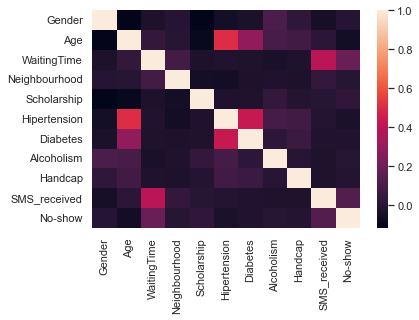

In [14]:
# process correlating features
corr = df.corr()
sns.heatmap(corr,
            xticklabels = corr.columns,
            yticklabels = corr.columns)
df.drop('Hipertension', axis=1, inplace=True)
df.drop('SMS_received', axis=1, inplace=True)

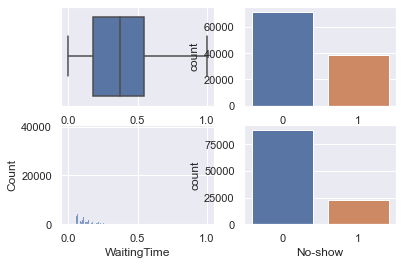

In [15]:
plt.subplot(2, 2, 1)
sns.boxplot(x = df['Age'])
plt.subplot(2, 2, 2)
sns.countplot(x = df['Gender'])
plt.subplot(2, 2, 3)
sns.histplot(x = df['WaitingTime'])
plt.subplot(2, 2, 4)
sns.countplot(x = df['No-show'])
plt.show()

In [16]:
y = df.pop('No-show')
X = df.copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    random_state=20)

In [17]:
svm = SVC(kernel='rbf', random_state=0, gamma=.10, C=1.0)
svm.fit(X_train, y_train)
y_predicted = svm.predict(X_test)

print(m = metrics.confusion_matrix(y_predicted , y_test))

print('The accuracy of the SVM classifier on training data is {:.2f}'.format(svm.score(X_train, y_train)))
print('The accuracy of the SVM classifier on test data is {:.2f}'.format(svm.score(X_test, y_test)))

The accuracy of the SVM classifier on training data is 0.80
The accuracy of the SVM classifier on test data is 0.80


KeyboardInterrupt: 

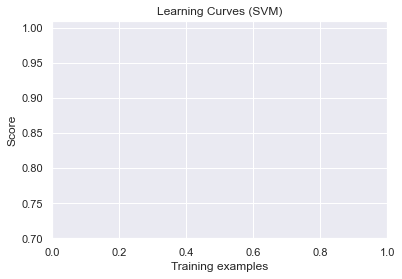

In [18]:
title = r"Learning Curves (SVM)"
plot_learning_curve(svm, title, X, y, ylim=(0.7, 1.01), cv=None, n_jobs=8)
plt.show()